# Predict Bike Availability using Tree-Based Models

In this report we predict bike availability for future (with horizon time of 15 minutes) using tree-based models.

In [1]:
# load packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display

# load custom modules
import sys
sys.path.append("../data_preprocessing/")
from prepare_data_for_ML import prepare_data_for_ML
import plotting_tools as vs

In [2]:
# show the figures within the notebook
%matplotlib inline

# Select ggplot as style
plt.style.use("ggplot")

## Prepare the Data

In [3]:
# build a custom object for station_id = 2
#nrows = 10002; station_ids = [2]
nrows = None; station_ids = [67]
obj = prepare_data_for_ML(status_data_path="../data/status_time_res_15min.csv",
                          weather_data_path="../data/weather_fixed.csv",
                          nrows=nrows, station_ids=station_ids)

# prepare the data for Random Forestb
df = obj.prepare_data_for_RF()

# display the data
display(df.head())

# show the number of rows and columns
print("This table has {npnts} data points and {col} columns.".format(npnts=df.shape[0], col=df.shape[1]))

,station_id,bikes_available,time_of_day,day_of_week,month_of_year,mean_temperature_f,mean_humidity,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,events,bikes_available_future
936826,67,1,1215,3,8,68.0,75.0,10.0,11.0,0.0,Normal,0.0
936827,67,0,1230,3,8,68.0,75.0,10.0,11.0,0.0,Normal,1.0
936828,67,1,1245,3,8,68.0,75.0,10.0,11.0,0.0,Normal,2.0
936829,67,2,1300,3,8,68.0,75.0,10.0,11.0,0.0,Normal,0.0
936830,67,0,1315,3,8,68.0,75.0,10.0,11.0,0.0,Normal,1.0


This table has 69894 data points and 12 columns.


### Encode Categorical Features

In [4]:
predictors = df.drop(["station_id", "bikes_available_future"], axis=1)
response = df[['bikes_available_future']]

# One-hot encode the categorical features
predictors = pd.get_dummies(predictors)

# display the predictors
display(predictors.head())

# show the number of rows and columns in predictors dataframe after one-hot-encoding
print("After one-hot-encoding, the number of predictors become {col}.".format(col=predictors.shape[1]))

,bikes_available,day_of_week,month_of_year,mean_temperature_f,mean_humidity,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,time_of_day_0000,time_of_day_0015,...,time_of_day_2245,time_of_day_2300,time_of_day_2315,time_of_day_2330,time_of_day_2345,events_Fog,events_Fog-Rain,events_Normal,events_Rain,events_Rain-Thunderstorm
936826,1,3,8,68.0,75.0,10.0,11.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
936827,0,3,8,68.0,75.0,10.0,11.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
936828,1,3,8,68.0,75.0,10.0,11.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
936829,2,3,8,68.0,75.0,10.0,11.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
936830,0,3,8,68.0,75.0,10.0,11.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0


After one-hot-encoding, the number of predictors become 109.


### Shuffle and Split the Data

In [5]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=100)

# convert column vector y into a 1d array to avoid some warning messages later
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 55915 samples.
Testing set has 13979 samples.


## Build a Random Forest Model

### Creating a Training and Predicting Pipeline

In [6]:
# use mean absolute error as model eveluation metrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """
    Parameters
    ----------
    learner :  
        the learning algorithm to be trained and predicted on
    sample_size : int
        the size of samples (number) to be drawn from training set
    X_train : Pandas.DataFrame 
        predictors in training set
    y_train : Pandas.DataFrame
        response in training set
    X_test : Pandas.DataFrame
        predictors in testing set
    y_test : Pandas.DataFrame
        response in testing set
        
    Returns
    -------
    dict
        a dictionalry object that holdes various results related to model eveluation 
    """
    
    from time import time
    
    results = {}
    
    # fit the learner to the training data using slicing with 'sample_size'
    X_train_sample = X_train[:sample_size]
    y_train_sample = y_train[:sample_size]
    start = time() # Get start time
    learner = learner.fit(X_train_sample, y_train_sample)
    end = time() # Get end time
    
    # calculate the training time
    results['train_time'] = end - start
        
    # get the predictions on the test set,
    # then get predictions on the training set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_sample)
    end = time() # Get end time
    
    # calculate the total prediction time
    results['pred_time'] = end-start
            
    # compute mean_absolute_error on the training and testing sets
    results['mean_absolute_error_train'] = mean_absolute_error(predictions_train, y_train_sample)
    results['mean_absolute_error_test'] = mean_absolute_error(predictions_test, y_test)

    # compute mean_squared_error on the training and testing sets
    results['mean_squared_error_train'] = mean_squared_error(predictions_train, y_train_sample)
    results['mean_squared_error_test'] = mean_squared_error(predictions_test, y_test)
       
    # some info messages
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # return the results
    return results

### Initial Model Eveluation

LinearRegression trained on 559 samples.
LinearRegression trained on 5591 samples.
LinearRegression trained on 55915 samples.
GradientBoostingRegressor trained on 559 samples.
GradientBoostingRegressor trained on 5591 samples.
GradientBoostingRegressor trained on 55915 samples.
RandomForestRegressor trained on 559 samples.
RandomForestRegressor trained on 5591 samples.
RandomForestRegressor trained on 55915 samples.


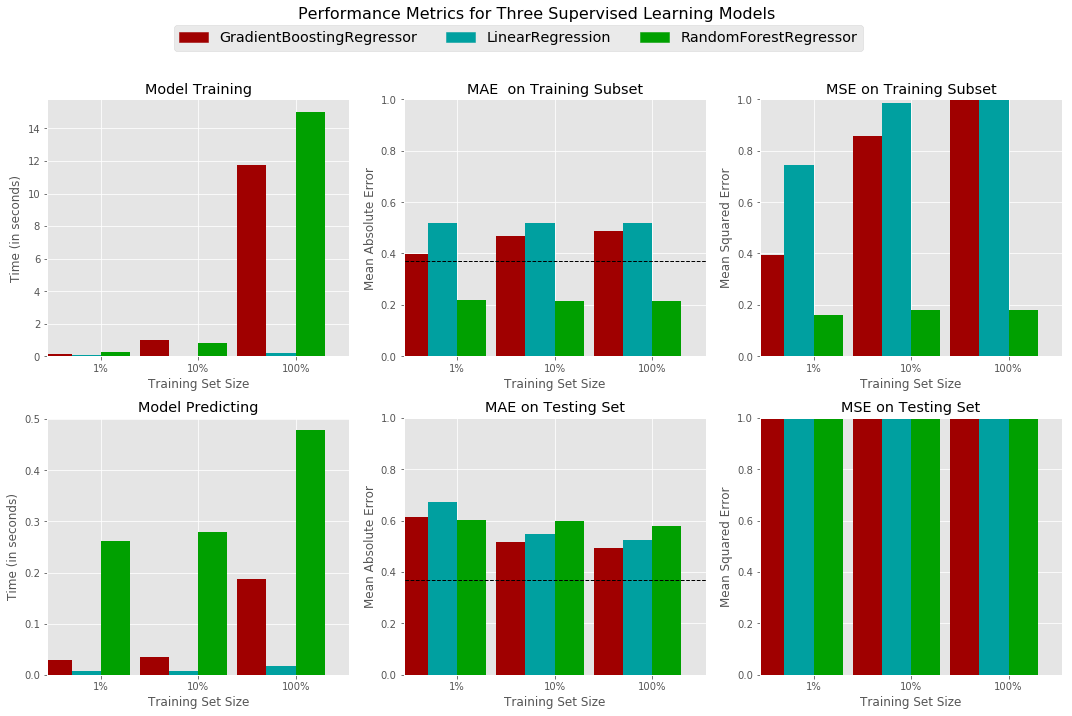

In [7]:
from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the three models
# build a linear regression
clf_LR = LinearRegression(n_jobs=6)

# build a Decision Tree model
clf_GB = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=100,random_state=100)

# build a Random Forest model
clf_RF = RandomForestRegressor(n_estimators=50, n_jobs=6, random_state=100)

# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(0.01 * len(X_train))
samples_10 = int(0.1 * len(X_train))
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_LR, clf_GB, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three supervised learning models chosen
benchmard_mean_absolute_error = 0.37
vs.evaluate(results, benchmard_mean_absolute_error)

In [8]:
#results[clf_DT.__class__.__name__]
results

{'GradientBoostingRegressor': {0: {'mean_absolute_error_test': 0.61600814761920819,
   'mean_absolute_error_train': 0.39696667433072053,
   'mean_squared_error_test': 1.3876149487764837,
   'mean_squared_error_train': 0.39455707135612783,
   'pred_time': 0.02828383445739746,
   'train_time': 0.10846400260925293},
  1: {'mean_absolute_error_test': 0.51558497092262634,
   'mean_absolute_error_train': 0.46684893477175649,
   'mean_squared_error_test': 1.1660969222337225,
   'mean_squared_error_train': 0.85582988968129425,
   'pred_time': 0.035138845443725586,
   'train_time': 1.0019519329071045},
  2: {'mean_absolute_error_test': 0.4940826657579277,
   'mean_absolute_error_train': 0.48711788241972309,
   'mean_squared_error_test': 1.1436062041640991,
   'mean_squared_error_train': 1.0285455611170058,
   'pred_time': 0.18782496452331543,
   'train_time': 11.759801864624023}},
 'LinearRegression': {0: {'mean_absolute_error_test': 0.67378203044574536,
   'mean_absolute_error_train': 0.518019

## Improving Results

### Choosing the Best Model

### Model Tuning

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

# Initialize RF Regressor
clf = RandomForestRegressor(n_estimators=50, random_state=100)

# the parameters list to be tuned
parameters = {"n_estimators" : np.arange(10,200, 10)}

# make a mean_absolute_error scoring object
scorer = make_scorer(mean_absolute_error)

# Perform grid search on the RF Regressor using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, n_jobs=4, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test, predictions))
print "Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test, predictions))
print "\nOptimized Model\n------"
print "Final mean absolute error on the testing data: {:.4f}".format(mean_absolute_error(y_test, best_predictions))
print "Final mean squared error on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions))

# Report the parameters of the best model
print "\nOptimized Model parameters\n------"
print "Best parameters found by GridSearchCV:"
print grid_fit.best_params_

Unoptimized model
------
Mean absolute error on testing data: 0.5788
Mean squared error on testing data: 1.3267

Optimized Model
------
Final mean absolute error on the testing data: 0.6011
Final mean squared error on the testing data: 1.3834

Optimized Model parameters
------
Best parameters found by GridSearchCV:
{'n_estimators': 10}

Feature ranking:
1. bikes_available (0.959290%)
2. day_of_week (0.005924%)
3. month_of_year (0.005349%)
4. mean_temperature_f (0.004290%)
5. mean_humidity (0.004055%)
6. mean_visibility_miles (0.003934%)
7. mean_wind_speed_mph (0.001180%)
8. precipitation_inches (0.001155%)
9. time_of_day_0000 (0.000477%)
10. time_of_day_0015 (0.000440%)


In [14]:
# Rank the features in Descending order
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
importances = importances[indices]

# Print the top 20 feature ranking
print("\nFeature ranking:")

for f in range(20):
    print("%d. %s (%f%%)" % (f + 1, X_train.columns[f], importances[f]))


Feature ranking:
1. bikes_available (0.959290%)
2. day_of_week (0.005924%)
3. month_of_year (0.005349%)
4. mean_temperature_f (0.004290%)
5. mean_humidity (0.004055%)
6. mean_visibility_miles (0.003934%)
7. mean_wind_speed_mph (0.001180%)
8. precipitation_inches (0.001155%)
9. time_of_day_0000 (0.000477%)
10. time_of_day_0015 (0.000440%)
11. time_of_day_0030 (0.000410%)
12. time_of_day_0045 (0.000404%)
13. time_of_day_0100 (0.000374%)
14. time_of_day_0115 (0.000356%)
15. time_of_day_0130 (0.000352%)
16. time_of_day_0145 (0.000341%)
17. time_of_day_0200 (0.000338%)
18. time_of_day_0215 (0.000335%)
19. time_of_day_0230 (0.000314%)
20. time_of_day_0245 (0.000310%)
